<div class="alert alert-block alert-info">
    
## Аналитика в Яндекс.Афише

#### Задание: помочь маркетологам оптимизировать маркетинговые затраты.
    
    
    
</div>

### Оглавление:  
1. [Шаг 1](#step1) Загрузка данных и подготовка к анализу. 
2. [Шаг 2](#step2) Построение отчётов и расчет метрик.
2. [Шаг 3](#step3) Вывод. Рекомендации маркетологам, куда и сколько им стоит вкладывать денег?

### Описание данных:
#### Таблица visits (лог сервера с информацией о посещениях сайта):
- Uid — уникальный идентификатор пользователя
- Device — категория устройства пользователя
- Start Ts — дата и время начала сессии
- End Ts — дата и время окончания сессии
- Source Id — идентификатор рекламного источника, из которого пришел пользователь

#### Таблица orders (информация о заказах):
- Uid — уникальный id пользователя, который сделал заказ
- Buy Ts — дата и время заказа
- Revenue — выручка Яндекс.Афиши с этого заказа

#### Таблица costs (информация о затратах на маркетинг):
- source_id — идентификатор рекламного источника
- dt — дата
- costs — затраты на этот рекламный источник в этот день

Произведем импортирование необходимых для работы библиотек.

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

### Шаг 1. Загрузка данных и подготовка их к анализу <a id="step1"></a>   
</div>

In [2]:
visits = pd.read_csv('/datasets/visits_log.csv')
visits.head()

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


Сразу же заменим названия столбцов на более удобные.

In [3]:
visits.columns = ['device', 'end_ts', 'source_id', 'start_ts', 'uid']

In [4]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device       359400 non-null object
end_ts       359400 non-null object
source_id    359400 non-null int64
start_ts     359400 non-null object
uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [5]:
orders = pd.read_csv('/datasets/orders_log.csv')
orders.head()

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


Сделаем в этом дф название столбца dt, так как необходимо будет объединять с дф costs по двум столбцам: source_id и dt.

In [6]:
orders.columns = ['buy_ts', 'revenue', 'uid']

In [7]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
buy_ts     50415 non-null object
revenue    50415 non-null float64
uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


Для объединения в дальнейшем создадим дополнительный столбец, в котором будет день из даты покупки.

In [8]:
orders['day'] = pd.DatetimeIndex(orders['buy_ts']).day
orders['month'] = pd.DatetimeIndex(orders['buy_ts']).month

In [9]:
costs = pd.read_csv('/datasets/costs.csv')
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [10]:
costs['day'] = pd.DatetimeIndex(costs['dt']).day
costs['month'] = pd.DatetimeIndex(costs['dt']).month

In [11]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 5 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
day          2542 non-null int64
month        2542 non-null int64
dtypes: float64(1), int64(3), object(1)
memory usage: 99.4+ KB


Cоздадим таблицу профилей пользователей, где каждому пользователю соответствует одна (первая) запись.

In [12]:
users = (visits.sort_values(by = ['uid', 'start_ts']).groupby('uid')
               .agg({'start_ts' : 'first', 'end_ts' : 'first', 'source_id': 'first', 'device': 'first'})
        )

In [13]:
afisha = users.merge(orders, on='uid', how='inner')

In [14]:
afisha = afisha.merge(costs, on=['day', 'month', 'source_id'], how='inner')

In [15]:
afisha['start_ts'] = pd.to_datetime(afisha['start_ts'], format='%Y-%m-%d %H:%M:%S')
afisha['end_ts'] = pd.to_datetime(afisha['end_ts'], format='%Y-%m-%d %H:%M:%S')

Из таблицы afisha не будем убирать все пропущенные значения. В этой таблице остануться без пропущенных значений только те пользователи, которые сделали заказ. Так как если у них нет времени заказа и выручки, то и заказа они не делали. При анализе этой таблицы разберемся почему не производился заказ.

In [16]:
afisha.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50414 entries, 0 to 50413
Data columns (total 11 columns):
uid          50414 non-null uint64
start_ts     50414 non-null datetime64[ns]
end_ts       50414 non-null datetime64[ns]
source_id    50414 non-null int64
device       50414 non-null object
buy_ts       50414 non-null object
revenue      50414 non-null float64
day          50414 non-null int64
month        50414 non-null int64
dt           50414 non-null object
costs        50414 non-null float64
dtypes: datetime64[ns](2), float64(2), int64(3), object(3), uint64(1)
memory usage: 4.6+ MB


Посмотрим пропущенные значения в дф.

In [17]:
afisha.isna().sum()

uid          0
start_ts     0
end_ts       0
source_id    0
device       0
buy_ts       0
revenue      0
day          0
month        0
dt           0
costs        0
dtype: int64

Посмотрим также, есть ли дубликаты в дф.

In [18]:
afisha.duplicated().sum()

0

Объединение таблиц завершено, теперь все данные в одном месте и можно приступать к анализу.

### Шаг 2. Построение отчётов и расчет метрик <a id="step2"></a>   
</div>

### Блок 1. Продукт

#### 2.1. Сколько людей пользуются в день, неделю, месяц?

Добавим столбцы с цифрой дня недели и месяца сессии.

In [19]:
afisha['day_month'] = afisha['start_ts'].astype('datetime64[D]')
afisha['day_session'] = pd.DatetimeIndex(afisha['start_ts']).day
afisha['day_session'] = afisha['day_session'].astype('int')
afisha['week_session'] = pd.DatetimeIndex(afisha['start_ts']).week
afisha['week_session'] = afisha['week_session'].astype('int')
afisha['month_session'] = pd.DatetimeIndex(afisha['start_ts']).month
afisha['month_session'] = afisha['month_session'].astype('int')

Сделаем группировку по дню, неделе и месяцу сессии с количеством пользователей в определенный период. И по этим таблицам сделаем графики. В графике с днем мы увидим цифры за день в каждом месяце. Применим метод nunique, чтобы получить именно уникальное количество пользователей, а не количество всех пользователей с повторениями.

In [20]:
day_group = afisha.groupby(['day_session', 'day_month']).agg({'uid':'nunique'})
day_user_group = day_group.groupby('day_session').agg({'uid':'mean'})

Воспользовавшись методом describe() определим общие параметры этой таблицы.

In [21]:
day_user_group.describe()

,uid
count,31.000000
mean,101.399560
std,11.481523
min,87.250000
25%,94.977273
50%,99.083333
75%,104.416667
max,148.833333


Из этих данных мы видим, что в день сервисом пользуется 101 человек.

Text(0.5, 1.0, 'Количество пользователей по дням')

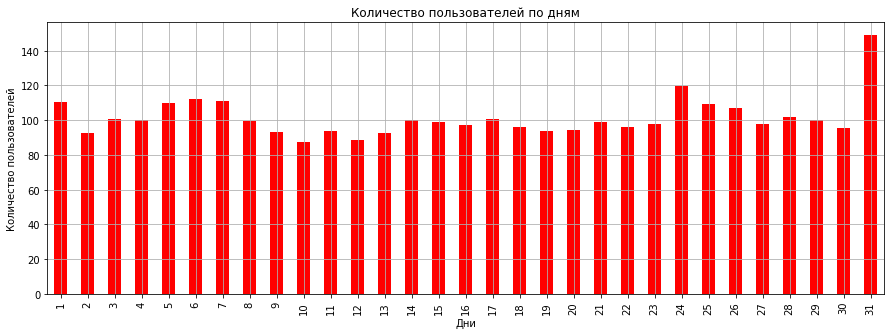

In [22]:
day_user_group.plot(kind='bar', grid=True, figsize=(15,5), linewidth=5, color='r', legend=False)
plt.ylabel('Количество пользователей')
plt.xlabel('Дни')
plt.title('Количество пользователей по дням')

В течение месяца нет какого то явного распределения пользователей по дням.

In [23]:
week_group = afisha.groupby('week_session').agg({'uid':'nunique'})

Text(0.5, 1.0, 'Количество пользователей по неделям')

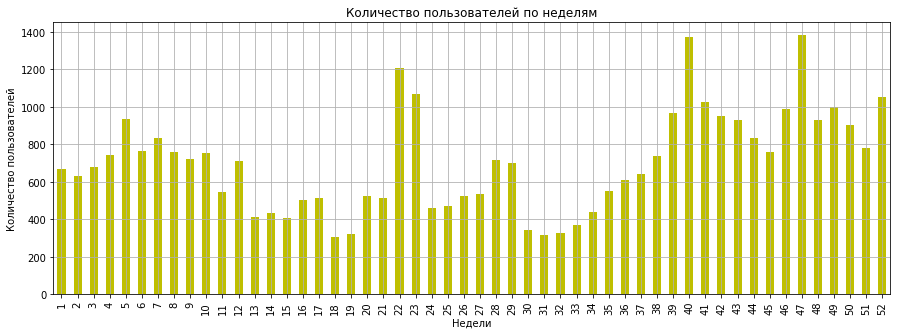

In [24]:
week_group.plot(kind='bar', grid=True, figsize=(15,5), linewidth=5, color='y', legend=False)
plt.ylabel('Количество пользователей')
plt.xlabel('Недели')
plt.title('Количество пользователей по неделям')

Также рассмотрим общие данные таблицы распределения пользователей в неделю.

In [25]:
week_group.describe()

,uid
count,52.000000
mean,702.346154
std,266.288866
min,303.000000
25%,509.250000
50%,705.500000
75%,907.750000
max,1382.000000


А в неделю пользователей сервиса получается 702 человека.

In [26]:
month_group = afisha.groupby('month_session').agg({'uid':'nunique'})

Text(0.5, 1.0, 'Количество пользователей в месяц')

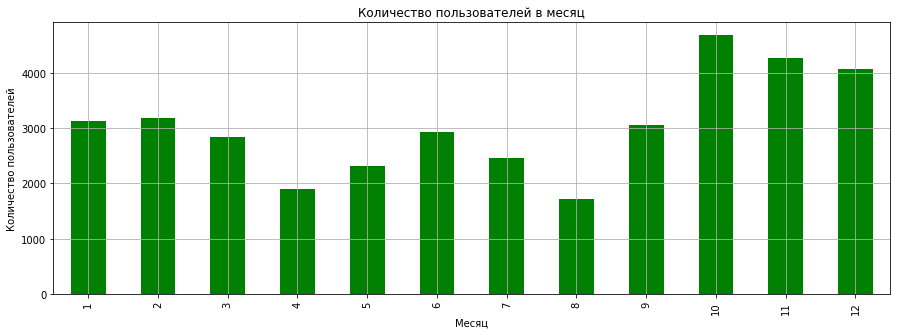

In [27]:
month_group.plot(kind='bar', grid=True, figsize=(15,5), linewidth=5, color='g', legend=False)
plt.ylabel('Количество пользователей')
plt.xlabel('Месяц')
plt.title('Количество пользователей в месяц')

In [28]:
month_group.describe()

,uid
count,12.000000
mean,3043.500000
std,917.284084
min,1720.000000
25%,2422.500000
50%,2990.500000
75%,3408.000000
max,4678.000000


По полученным данным получается, что у сервиса 3043 клиента в месяц.

Мы видим по графику по неделям и по месяцам, что летом количество пользователей Яндекс.Афиши резко уменьшается. Это связано с тем, что летом люди стараюются уехать из города на отдых. Также летом происходят театральные каникулы, а значит некоторый пласт пользователей, который увлекается театром отпадает.

#### 2.2. Сколько сессий в день?

Отобразим графики количества пользователей и количества сессий в день рядом, чтобы отследить одинаковая ли динамика.

In [29]:
day_session = afisha.groupby(['day_session', 'day_month']).agg({'start_ts':'count'})
day_session_group = day_session.groupby('day_session').agg({'start_ts':'mean'})

Text(0.5, 1.0, 'Количество сессий в день')

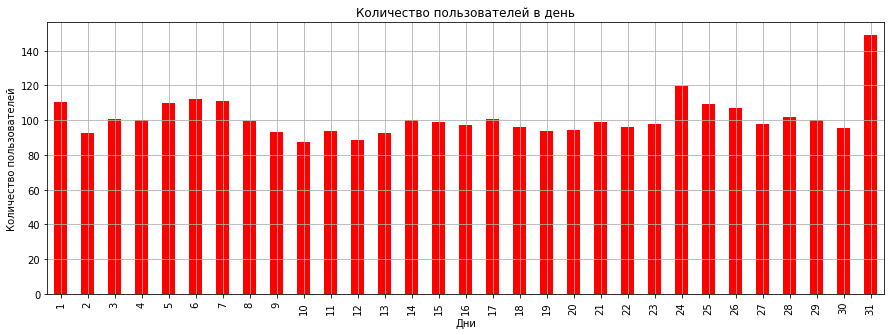

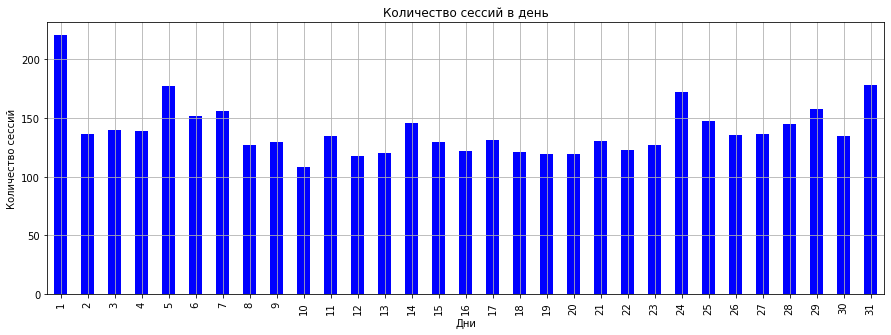

In [30]:
day_user_group.plot(kind='bar', grid=True, figsize=(15,5), linewidth=5, color='r', legend=False)
plt.ylabel('Количество пользователей')
plt.xlabel('Дни')
plt.title('Количество пользователей в день')
day_session_group.plot(kind='bar', grid=True, figsize=(15,5), linewidth=5, color='b', legend=False)
plt.ylabel('Количество сессий')
plt.xlabel('Дни')
plt.title('Количество сессий в день')

Когда эти графики рядом мы можем заметить, что когда растет количество пользователей - растет и количество сессий. И в обратную сторону.

In [31]:
day_session_group.describe()

,start_ts
count,31.000000
mean,139.773216
std,22.858076
min,108.583333
25%,124.625000
50%,135.000000
75%,146.500000
max,220.454545


Среднее количество сессий в день равно 139,8. Учитывая, что пользователей в день выходит 101, значит клиенты обращаются к сервису в день повторно.

#### 2.3. Сколько длится одна сессия?

Создадим столбец длительность сессии. Вычтем из даты конца сессии дату начала сессии.

In [32]:
afisha_duration = afisha.copy(deep=True)

In [33]:
afisha_duration['start_ts'] = pd.to_datetime(afisha_duration['start_ts'], format='%Y-%m-%d %H:%M:%S')
afisha_duration['end_ts'] = pd.to_datetime(afisha_duration['end_ts'], format='%Y-%m-%d %H:%M:%S')

In [34]:
afisha_duration['duration_of_session_sec'] = (afisha_duration['end_ts'] - afisha_duration['start_ts']).dt.seconds

Text(0.5, 1.0, 'Продолжительность сессий, сек.')

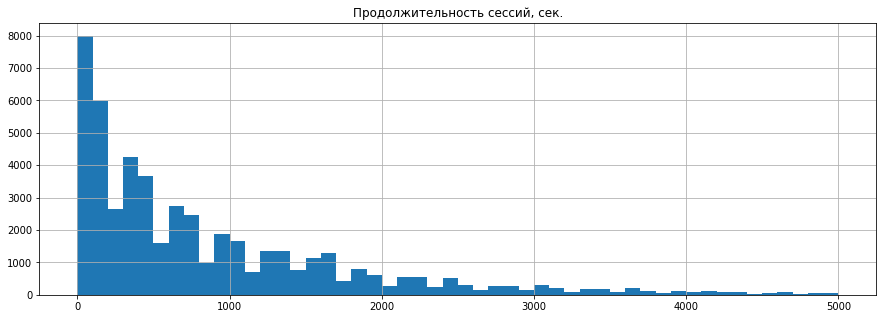

In [35]:
afisha_duration['duration_of_session_sec'].hist(bins=50, range=(0,5000), figsize=(15,5))
plt.title('Продолжительность сессий, сек.')

Найдем моду, или наиболее часто встречающееся значение продолжительности сессии в секундах

In [36]:
asl = afisha_duration['duration_of_session_sec'].mode()
print(asl)

0    60
dtype: int64


Мы видим, что самое большое количество сессий длятся до 60 секунд. А максимальное количество сессий лежат в промежутке до 2000 секунд, а это примерно 35 минут.

#### 2.4. Как часто люди возвращаются?

Проведем когортный анализ. За основу возьмем исходный датафрейм visits, так как в нем меньше данных, чтобы сократить время обработки. А еще там нет измененных в предобработке данных.

Сначала создадим series с датой самой первой активности и добавим ее в исходный датафрейм.

In [37]:
first_activity_dates = visits.groupby('uid')['start_ts'].min()
first_activity_dates.name = 'first_activity_dates'
visits = visits.join(first_activity_dates,on='uid')

Изменим тип данных у столбцов с датами на месяц активности.

In [38]:
visits['activity_month'] = visits['start_ts'].astype('datetime64[M]')
visits['first_activity_month'] = visits['first_activity_dates'].astype('datetime64[M]')

Создадим столбец с жизненным циклом когорты.

In [39]:
visits['cohort_lifetime'] = visits['activity_month'] - visits['first_activity_month']
visits['cohort_lifetime'] = visits['cohort_lifetime'] / np.timedelta64(1,'M')
visits['cohort_lifetime'] = visits['cohort_lifetime'].round().astype('int')

In [40]:
cohorts = visits.groupby(['first_activity_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()

Определим сколько пользователей было изначально в нулевом жизненном цикле.

In [41]:
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_activity_month','uid']]

In [42]:
initial_users_count

,first_activity_month,uid
0,2017-06-01,13259
12,2017-07-01,13140
23,2017-08-01,10181
33,2017-09-01,16704
42,2017-10-01,25977
50,2017-11-01,27248
57,2017-12-01,25268
63,2018-01-01,22624
68,2018-02-01,22197
72,2018-03-01,20589


In [43]:
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'})

In [44]:
cohorts = cohorts.merge(initial_users_count,on='first_activity_month')

Посчитаем retention для когорт.

In [45]:
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users']

In [46]:
cohorts['first_activity_month'] = cohorts['first_activity_month'].dt.strftime('%Y-%m')

И в конечном итоге создадим итоговую сводную таблицу с когортами по жизненным циклам.

In [47]:
retention_pivot = cohorts.pivot_table(index='first_activity_month',columns='cohort_lifetime',values='retention',aggfunc='sum')
retention_pivot

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_activity_month,,,,,,,,,,,,
2017-06,1.0,0.078664,0.053775,0.061392,0.068557,0.071423,0.061015,0.057772,0.052342,0.050833,0.040652,0.044951
2017-07,1.0,0.056088,0.051294,0.056164,0.058219,0.048174,0.045358,0.045738,0.038813,0.028615,0.027473,NaN
2017-08,1.0,0.076908,0.062862,0.062764,0.050093,0.044004,0.036342,0.039485,0.027895,0.026029,NaN,NaN
2017-09,1.0,0.085489,0.069205,0.050706,0.039392,0.037835,0.035860,0.024186,0.022809,NaN,NaN,NaN
2017-10,1.0,0.078608,0.052239,0.038958,0.034261,0.032221,0.021365,0.020364,NaN,NaN,NaN,NaN
2017-11,1.0,0.078281,0.044113,0.038682,0.033727,0.023415,0.021800,NaN,NaN,NaN,NaN,NaN
2017-12,1.0,0.055802,0.037993,0.031107,0.020263,0.019036,NaN,NaN,NaN,NaN,NaN,NaN
2018-01,1.0,0.059715,0.039339,0.024973,0.020244,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02,1.0,0.057080,0.025454,0.020093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Для наглядности построим heatmap.

Text(114.0, 0.5, 'Когорты')

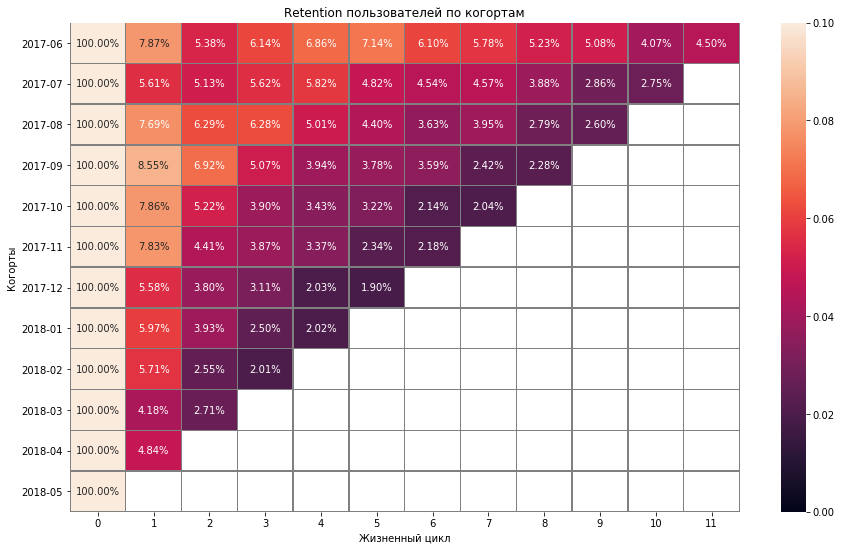

In [48]:
plt.figure(figsize=(15, 9))
plt.title('Retention пользователей по когортам')
sns.heatmap(retention_pivot, annot=True, fmt='.2%', linewidths=0.5, linecolor='gray', vmin=0, vmax= 0.1)
plt.xlabel('Жизненный цикл')
plt.ylabel('Когорты')

Мы видим, что возвращаются люди очень редко по сравнению с самым первым циклом. 
- Больше всех показатель возвращаемости у первой когорты. Там отметка возврата не падает ниже 4%. 
- На второй период больше всего вернулось пользователей в когорте 2017-09.

Возможно сервису необходимо вести более активную рекламную кампанию и придумать какие- нибудь программы лояльности, чтобы пользователи чаще возвращались.

### Блок 2. Продажи

Для этого блока будем использовать когортный анализ.

#### 2.6. Когда люди начинают покупать?

Сначала создадим series c самой первой покупккой для каждого пользователя.

Чтобы продолжать работу с исключительно покупающими пользователями - мы уберем пропущенные значения из дф afisha.

In [49]:
afisha_order = afisha.dropna()
afisha_order = afisha_order.reset_index()
afisha_order = afisha_order.drop('index', axis=True)

In [50]:
first_order_dates = afisha_order.groupby('uid')['buy_ts'].min()
first_order_dates.name = 'first_order_dates'

In [51]:
afisha_order = afisha_order.join(first_order_dates, on='uid')
afisha_order['order_month'] = afisha_order['buy_ts'].astype('datetime64[M]')
afisha_order['first_order_month'] = afisha_order['first_order_dates'].astype('datetime64[M]')

Когортой станет столбец first_order_month.

Посмотрим на распределение покупателей по когортам.

In [52]:
cohort_grouped_one = afisha_order.groupby('first_order_month').agg({'uid':'nunique', 'revenue':'sum'})
cohort_grouped_one

,uid,revenue
first_order_month,,
2017-06-01,2023,24031.69
2017-07-01,1923,16127.92
2017-08-01,1369,11605.04
2017-09-01,2581,34676.32
2017-10-01,4340,27603.45
2017-11-01,4081,26098.99
2017-12-01,4383,33485.74
2018-01-01,3373,16663.13
2018-02-01,3651,16750.50


Мы видим, что в наши данные затесался лишний пользователь с покупкой вне необходимого нам периода времени. Сделаем срез, чтобы удалить его. А так же добавим в cohort_grouped_one группировку еще по месяцу продажи, а не только по первому, так как до этого она бы нам мешала посмотреть таблицу по каждой когорте.

In [53]:
afisha_order = afisha_order.query('first_order_month != "2018-06-01"')

Больше всего пользователей и больше всего выручка в когортах за сентябрь и за январь. Это также может быть связано с тем, что в сентябре открывается театральный сезон, а в январе много выходных для различного рода досуга.

Также определим сколько времени прошло между первой активностью и первой покупкой.

Сделаем группировку и проведем арифметические вычисления разности. Для удобства вычисления переведем всю дату в часы.

In [54]:
between = afisha.copy(deep=True) 

In [55]:
between['start_ts'] = pd.to_datetime(afisha_duration['start_ts'], format='%Y-%m-%d %H:%M:%S')
between['buy_ts'] = pd.to_datetime(afisha_duration['end_ts'], format='%Y-%m-%d %H:%M:%S')

In [56]:
between = between.groupby('uid').agg({'start_ts':'first', 'buy_ts':'first', 'revenue':'sum'}).reset_index()

In [57]:
between['between_start_and_order'] = (between['buy_ts'] - between['start_ts']) / np.timedelta64(1,'h')

In [58]:
between['between_start_and_order'].describe()

count    36522.000000
mean         0.248797
std          0.299801
min          0.000000
25%          0.050000
50%          0.150000
75%          0.333333
max          6.533333
Name: between_start_and_order, dtype: float64

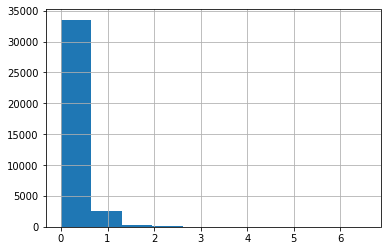

In [59]:
between['between_start_and_order'].hist()

Мы видим, что максимальные значения находились до 800 часов примерно, а все остальное по минимуму. Сделаем срез, чтобы посчитать среднее не по всем значениям, а по наиболее встречающимся.

In [60]:
between_mean = between.query('between_start_and_order < 800')
between_mean['between_start_and_order'].describe()

count    36522.000000
mean         0.248797
std          0.299801
min          0.000000
25%          0.050000
50%          0.150000
75%          0.333333
max          6.533333
Name: between_start_and_order, dtype: float64

Из данного среза мы видим, что в среднем между первой активностью и первой покупкой произошло 45.8 минут. Похоже на правду, ведь в это время входит выбор продукта, а также оформление заказа.

#### 2.6. Сколько раз покупают за период?

Определим изменение в количестве покупателей по периодам для каждой когорты.

In [61]:
buy_per_period = afisha_order.copy(deep=True) 

In [62]:
buy_per_period['order_month'] = buy_per_period['order_month'].dt.strftime('%Y-%m')

In [63]:
cohort_grouped = buy_per_period.groupby('order_month').agg({'first_order_month':'count', 'uid':'nunique', 'revenue':'sum'})

In [64]:
cohort_grouped = buy_per_period.groupby('order_month').agg({'first_order_month':'count', 'uid':'nunique', 'revenue':'sum'})
cohort_grouped.columns = ['total_buyers', 'n_buyers', 'revenue']
cohort_grouped['buy_per_buyers'] = cohort_grouped['total_buyers'] / cohort_grouped['n_buyers']
cohort_grouped.head()

,total_buyers,n_buyers,revenue,buy_per_buyers
order_month,,,,
2017-06,2354,2023,9557.49,1.163618
2017-07,2363,1984,12539.47,1.191028
2017-08,1806,1471,8757.56,1.227736
2017-09,3387,2750,18345.51,1.231636
2017-10,5679,4675,27987.70,1.214759


In [65]:
buyers = cohort_grouped.groupby('order_month').agg({'buy_per_buyers':'mean'})

Text(0.5, 1.0, 'Количество покупок на человека')

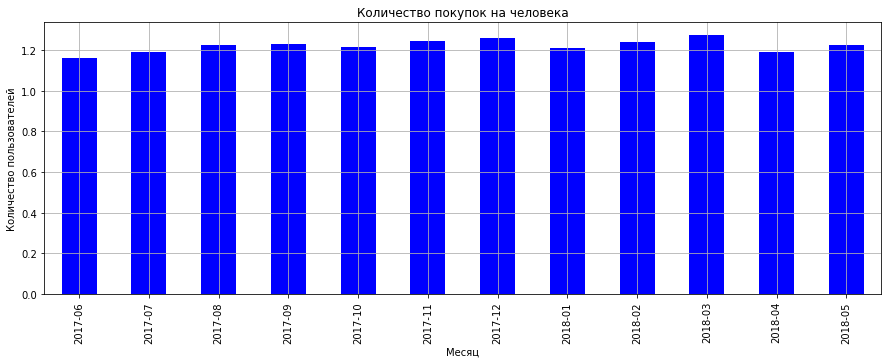

In [66]:
buyers.plot(kind='bar', grid=True, figsize=(15,5), linewidth=5, color='b', legend=False)
plt.ylabel('Количество пользователей')
plt.xlabel('Месяц')
plt.title('Количество покупок на человека')

По таблице мы видим, что:
- максимальное количество покупок на покупателя происходит в ноябре, декабре, феврале и марте.  Возможно, это связано с тем, что почти все люди покупают подарки. Затем количество покупок начинает стремительно уменьшаться;
- но также мы видим, что везде среднее число покупок больше единицы, это связано с тем, что в сервис люди все же возвращаются.


#### 2.7. Какой средний чек?

Найдём средний чек покупателя в когорте revenue_per_user — разделим показатель revenue на uid:

In [67]:
cohort_grouped_2 = buy_per_period.groupby(['first_order_month', 'order_month']).agg({'uid':'nunique', 'revenue':'sum'})
cohort_grouped_2.columns = ['n_buyers', 'revenue']

In [68]:
cohort_grouped_2['revenue_per_user'] = cohort_grouped_2['revenue'] / cohort_grouped_2['n_buyers']
cohort_grouped_2.head()

n_buyers  revenue  revenue_per_user
first_order_month order_month                                     
2017-06-01        2017-06          2023  9557.49          4.724414
                  2017-07            61   981.82         16.095410
                  2017-08            50   885.34         17.706800
                  2017-09            54  1931.30         35.764815
                  2017-10            88  2068.58         23.506591

Определим средний чек по периодам.

In [69]:
cohort_grouped_2.pivot_table(index='first_order_month',columns='order_month',values='revenue_per_user',aggfunc='mean')

order_month,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05
first_order_month,,,,,,,,,,,,
2017-06-01,4.724414,16.095410,17.706800,35.764815,23.506591,22.207761,31.011935,25.033191,19.295690,27.233556,25.681333,9.804151
2017-07-01,NaN,6.010218,12.396346,21.035965,10.786094,6.938163,7.896842,6.421111,6.992821,7.382143,12.861818,11.513846
2017-08-01,NaN,NaN,5.279481,11.148793,11.851321,12.182955,16.921250,12.139063,9.620333,12.610455,21.070000,8.307419
2017-09-01,NaN,NaN,NaN,5.644529,22.188385,13.445200,138.669189,19.881538,26.095000,27.437121,16.961351,11.044651
2017-10-01,NaN,NaN,NaN,NaN,5.003733,11.287427,6.753252,7.413152,7.072796,7.255139,6.573214,7.479701
2017-11-01,NaN,NaN,NaN,NaN,NaN,5.154683,7.339054,6.786583,12.510660,7.457284,4.580833,7.564839
2017-12-01,NaN,NaN,NaN,NaN,NaN,NaN,4.738191,7.816575,39.366019,48.135052,27.431400,23.518413
2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.135636,8.721228,12.365542,11.199767,4.699556
2018-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.156987,8.610000,4.942414,6.941026


А теперь необходимо посчитать какой средний чек выйдет в месяц на пользователя.

In [70]:
cohort_grouped['revenue_per_user'] = cohort_grouped['revenue'] / cohort_grouped['n_buyers']

In [71]:
cheque = cohort_grouped.groupby('order_month').agg({'revenue_per_user':'mean'})

Text(0.5, 1.0, 'Средний чек на пользователя')

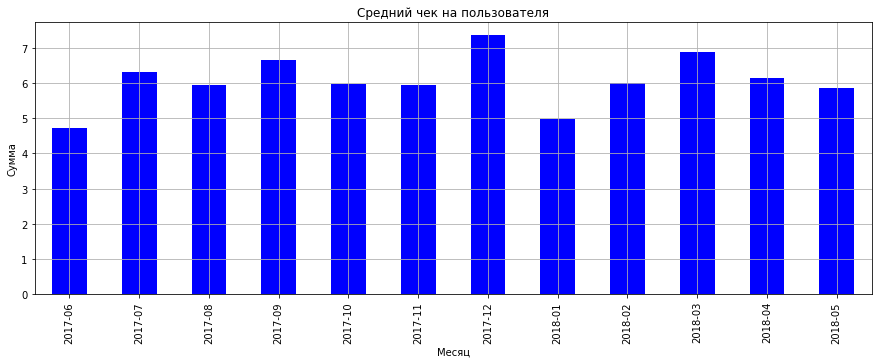

In [72]:
cheque.plot(kind='bar', grid=True, figsize=(15,5), linewidth=5, color='b', legend=False)
plt.ylabel('Сумма')
plt.xlabel('Месяц')
plt.title('Средний чек на пользователя')

Максимальный средний чек выходит в декабрьской когорте, когда все покупают подарки но Новый год.

#### 2.8. Сколько денег приносят? (LTV)

LTV удобно считать по когортам. Для этого нужно:
1. найти дату первой покупки каждого покупателя;

In [73]:
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])

orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')

first_orders = orders.groupby('uid').agg({'order_month': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_month']
first_orders = first_orders.query('first_order_month != "2018-06-01"')
cohort_sizes = first_orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']

2. вычислить число новых покупателей за каждую дату;
3. добавить дату первой покупки в таблицу с заказами;
4. сгруппировать таблицу и посчитать выручку.

In [74]:
first_order_month = pd.merge(orders,first_orders, on='uid')
cohorts = first_order_month.groupby(['first_order_month','order_month']).agg({'revenue': 'sum'}).reset_index()
report = pd.merge(cohort_sizes, cohorts, on='first_order_month')

Получили дробные числа. Это связано с тем, что константа np.timedelta64(1,'M') представляет собой среднюю длину месяца в году. В месяце бывает от 28 дней до 31, вот и числа вышли не целые. Округлим значения столбца cohort_lifetime методом round(), а затем приведём их к типу 'int'.

In [75]:
report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')

Получили целое число месяцев, обозначающее порядковый месяц совершения покупки относительно месяца первой покупки.

In [76]:
report['ltv'] = report['revenue'] / report['n_buyers']

In [77]:
report['first_order_month'] = report['first_order_month'].astype('datetime64[M]')
report['first_order_month'] = report['first_order_month'].dt.strftime('%Y-%m')

In [78]:
result = report.pivot_table(
    index='first_order_month', 
    columns='age', 
    values='ltv', 
    aggfunc='mean')

result

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06,4.724414,0.485329,0.437637,0.954671,1.022531,0.735502,0.950440,0.581592,0.553213,0.605788,0.571261,0.256856
2017-07,6.010218,0.335211,0.623531,0.358976,0.176791,0.156048,0.120208,0.141820,0.161232,0.147145,0.155673,NaN
2017-08,5.276518,0.471993,0.458482,0.391277,0.494051,0.283540,0.210664,0.405007,0.292212,0.187978,NaN,NaN
2017-09,5.644529,1.117586,0.520930,3.975792,0.400558,0.647067,0.701608,0.243150,0.184006,NaN,NaN,NaN
2017-10,5.003733,0.535763,0.191394,0.157145,0.151560,0.120362,0.084816,0.115470,NaN,NaN,NaN,NaN
2017-11,5.154683,0.399233,0.199556,0.324952,0.148013,0.053879,0.114928,NaN,NaN,NaN,NaN,NaN
2017-12,4.738191,0.260374,0.925097,1.065275,0.312930,0.338047,NaN,NaN,NaN,NaN,NaN,NaN
2018-01,4.135636,0.294758,0.304281,0.142778,0.062698,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02,4.156987,0.278274,0.078515,0.074144,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Создадим тепловую карту по полученной таблице.

Text(114.0, 0.5, 'Когорты')

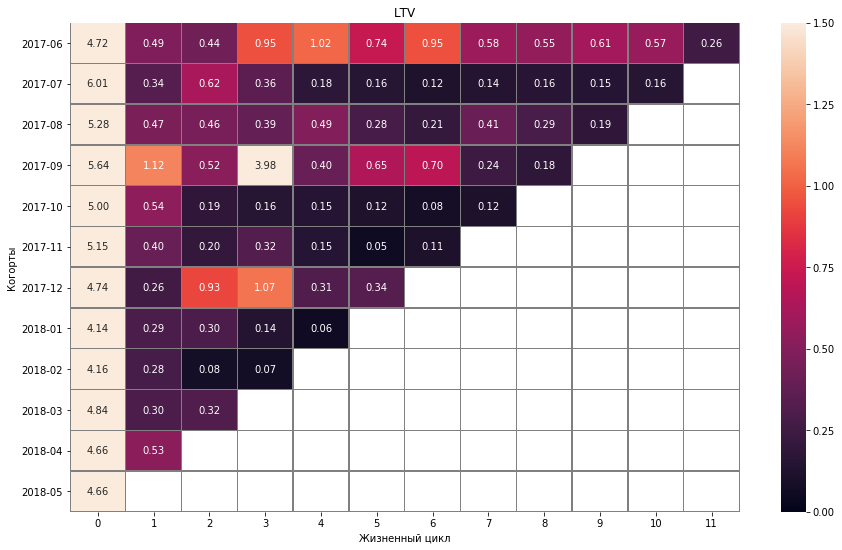

In [79]:
plt.figure(figsize=(15, 9))
plt.title('LTV')
sns.heatmap(result, annot=True, fmt='.2f', linewidths=0.5, linecolor='gray', vmin=0, vmax= 1.5)
plt.xlabel('Жизненный цикл')
plt.ylabel('Когорты')

Мы видим, что средний чек когорты 2017-09 сильно выделяется за 4 период. Он равен 3,98 и это максимальное значение во всей тепловой карте. Также в этом же периоде выделяется когорта 2017-06 и 2017-12. Видимо в этом периоде происходили какие- то массовые, популярные мероприятия. 

У когорт 2017-07 и 2017-10 оказались самые маленькие LTV.

### Блок 3. Маркетинг

#### 2.9. Сколько денег потратили? Всего / на каждый источник / по времени.

Чтобы ответить на данные вопросы сгруппируем по заданной теме затраты на маркетинг, а для наглдяности визуализируем, чтобы была видна динамика.

Всего на рекламную кампанию потратили:

In [80]:
total_costs = costs['costs'].sum()
total_costs

329131.62

Маркетинговые расходы разбитые по каждому источнику.

In [81]:
costs_per_source = costs.groupby('source_id').agg({'costs':'sum'})

Text(0.5, 1.0, 'Затраты на маркетинг по каждому источнику трафика')

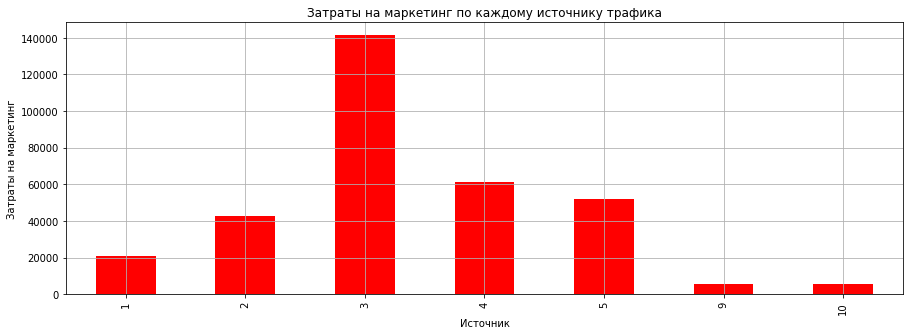

In [82]:
costs_per_source.plot(kind='bar', grid=True, figsize=(15,5), linewidth=5, color='r', legend=False)
plt.ylabel('Затраты на маркетинг')
plt.xlabel('Источник')
plt.title('Затраты на маркетинг по каждому источнику трафика')

Мы видим, что максимальные затраты пришлись на третий источник. А минимальные затраты на 9 и 10.

In [83]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 5 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
day          2542 non-null int64
month        2542 non-null int64
dtypes: float64(1), int64(3), object(1)
memory usage: 99.4+ KB


In [84]:
costs['dt'] = costs['dt'].astype('datetime64[M]')
costs.columns = ['source_id', 'order_month', 'costs', 'day', 'month']
costs_per_time = costs.groupby(['order_month', 'source_id']).agg({'costs':'sum'}).reset_index()
costs_per_time.head()

,order_month,source_id,costs
0,2017-06-01,1,1125.61
1,2017-06-01,2,2427.38
2,2017-06-01,3,7731.65
3,2017-06-01,4,3514.80
4,2017-06-01,5,2616.12


In [85]:
costs_per_time_2 = afisha_order.groupby('order_month').agg({'uid':'nunique'}).reset_index()
costs_per_time_2.columns = ['order_month', 'uid']

In [86]:
costs_month = costs_per_time.merge(costs_per_time_2, on='order_month')

In [87]:
costs_month['order_month'] = costs_month['order_month'].dt.strftime('%Y-%m')

In [88]:
costs_month_plot = costs_month.groupby('order_month').agg({'costs':'sum'})

Text(0.5, 1.0, 'Затраты на маркетинг по времени')

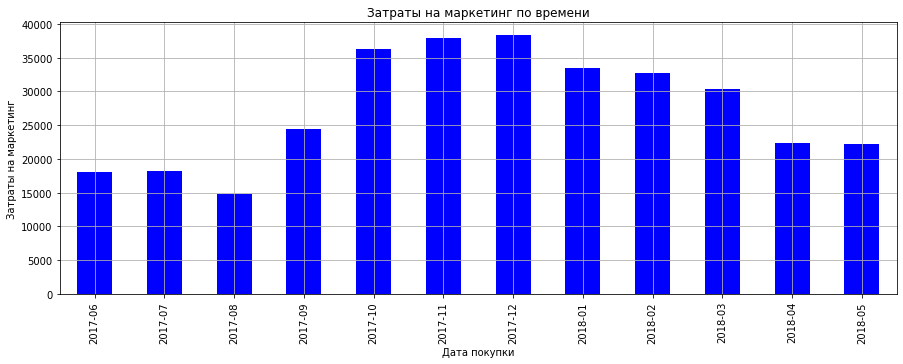

In [89]:
costs_month_plot.plot(kind='bar', grid=True, figsize=(15,5), linewidth=5, color='b', legend=False)
plt.ylabel('Затраты на маркетинг')
plt.xlabel('Дата покупки')
plt.title('Затраты на маркетинг по времени')

Выходит очень логичная ситуация. Минимальные затраты на рекламу приходятся на лето, когда человек старается максимально проводить время на улице. А максимальные затраты приходятся на предновогодний период, когда люди находятся в поисках новогодних подарков.

В графике пользователей мы видели аналогичную ситуацию, а значит рекламная кампания работает.

#### 2.10. Сколько стоило привлечение одного покупателя из каждого источника?

Создадим дополнительный дф, в котором будет группировка специально для расчета экономических показателей с группировкой по рекламным источникам.

In [90]:
order_cac = users.merge(orders, on='uid', how='left')
order_cac = order_cac.dropna()

Cгруппируем покупателей по источникам

In [91]:
uid_per_source = order_cac.groupby('source_id').agg({'uid':'nunique'})

Объединим с группировкой расходов по источникам.

In [92]:
cac_step = pd.merge(costs_per_source,uid_per_source, on='source_id')
cac_step['cac'] = cac_step['costs'] / cac_step['uid']
cac_step

,costs,uid,cac
source_id,,,
1,20833.27,2899,7.186364
2,42806.04,3506,12.209367
3,141321.63,10473,13.493901
4,61073.60,10296,5.931779
5,51757.10,6931,7.467479
9,5517.49,1088,5.071222
10,5822.49,1329,4.381106


Проверим правильное ли количество покупателей мы использовали.

In [93]:
order_cac['uid'].nunique()

36523

In [94]:
cac_step['uid'].sum()

36522

Получим месяц первой покупки каждого покупателя:

In [95]:
market_grouped = pd.merge(orders, users, on='uid')
market_grouped = market_grouped.dropna()
first_orders2 = market_grouped.groupby(['uid', 'source_id']).agg({'order_month': 'min'}).reset_index()
first_orders2.columns = ['uid', 'source_id', 'first_order_month']

Посчитаем количество новых покупателей (n_buyers) за каждый месяц.

In [96]:
cohort_sizes2 = first_orders2.groupby(['first_order_month', 'source_id']).agg({'uid': 'nunique'}).reset_index()
cohort_sizes2.columns = ['first_order_month', 'source_id', 'n_buyers']
cohort_sizes2.head()

,first_order_month,source_id,n_buyers
0,2017-06-01,1,190
1,2017-06-01,2,235
2,2017-06-01,3,638
3,2017-06-01,4,413
4,2017-06-01,5,384
...,...,...,...
81,2018-05-01,4,804
82,2018-05-01,5,497
83,2018-05-01,9,60
84,2018-05-01,10,130


In [97]:
orders_first_month = pd.merge(market_grouped,first_orders2, on=['uid', 'source_id'])

In [98]:
cohorts2 = orders_first_month.groupby(['first_order_month','order_month','source_id']).agg({'revenue': 'sum'}).reset_index()
cohorts2.head()

,first_order_month,order_month,source_id,revenue
0,2017-06-01,2017-06-01,1,1378.70
1,2017-06-01,2017-06-01,2,1043.68
2,2017-06-01,2017-06-01,3,2804.34
3,2017-06-01,2017-06-01,4,1959.84
4,2017-06-01,2017-06-01,5,1898.89


In [99]:
report2 = pd.merge(cohort_sizes2, cohorts2, on=['first_order_month', 'source_id'])
report2.head()

,first_order_month,source_id,n_buyers,order_month,revenue
0,2017-06-01,1,190,2017-06-01,1378.70
1,2017-06-01,1,190,2017-07-01,414.98
2,2017-06-01,1,190,2017-08-01,419.43
3,2017-06-01,1,190,2017-09-01,714.24
4,2017-06-01,1,190,2017-10-01,811.20


In [100]:
costs_grouped = costs.groupby(['order_month', 'source_id']).agg({'costs': 'sum'}).reset_index()
costs_grouped.head()

,order_month,source_id,costs
0,2017-06-01,1,1125.61
1,2017-06-01,2,2427.38
2,2017-06-01,3,7731.65
3,2017-06-01,4,3514.80
4,2017-06-01,5,2616.12


In [101]:
cac = pd.merge(report2,costs_grouped, on=['order_month', 'source_id'])
cac.head()

,first_order_month,source_id,n_buyers,order_month,revenue,costs
0,2017-06-01,1,190,2017-06-01,1378.70,1125.61
1,2017-06-01,1,190,2017-07-01,414.98,1072.88
2,2017-07-01,1,160,2017-07-01,1166.70,1072.88
3,2017-06-01,1,190,2017-08-01,419.43,951.81
4,2017-07-01,1,160,2017-08-01,175.31,951.81


In [102]:
cac['order_month'] = pd.to_datetime(cac['order_month'])
cac['first_order_month'] = pd.to_datetime(cac['first_order_month'])

In [103]:
cac['age'] = (cac['order_month'] - cac['first_order_month']) / np.timedelta64(1, 'M')
cac['age'] = cac['age'].round().astype('int')

Расчитаем дополнительные столбцы с LTV и CAC, чтобы определить какой расход на рекламу на одного клиента и сколько этот клиент приносит выручки.

In [104]:
cac['ltv'] = cac['revenue'] / cac['n_buyers']
cac['cac'] = cac['costs'] / cac['n_buyers']

Вынесем полученные данные в отдельную таблицу.

In [105]:
LTV = (cac.pivot_table(index='first_order_month', 
                                     columns='age', 
                                     values='ltv', 
                                     aggfunc='mean')
         )
LTV 

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.538087,0.560005,0.645660,1.322436,1.366870,0.898439,1.196362,0.829692,0.711626,0.720439,0.682914,0.467524
2017-07-01,5.798336,0.384558,1.116743,0.453061,0.311879,0.231463,0.199387,0.188278,0.238480,0.232743,0.252983,NaN
2017-08-01,5.356883,0.502769,0.487162,0.421881,0.499426,0.275007,0.245140,0.570430,0.452788,0.217570,NaN,NaN
2017-09-01,5.336339,1.704064,0.657591,2.769371,0.445724,0.595561,0.946744,0.325135,0.324358,NaN,NaN,NaN
2017-10-01,5.089034,0.708755,0.249292,0.193893,0.183837,0.172989,0.081489,0.129642,NaN,NaN,NaN,NaN
2017-11-01,5.282587,0.376777,0.268943,0.389857,0.159761,0.063625,0.094769,NaN,NaN,NaN,NaN,NaN
2017-12-01,4.909693,0.380088,1.686074,1.979828,0.542301,0.523458,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,4.041890,0.319214,0.393299,0.239937,0.085312,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,4.225858,0.349753,0.091439,0.142982,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Мы видим, что только первый lifetime доходы с покупателя превышают 1. В остальных случаях это скорее исключения.

In [106]:
CAC = (cac.pivot_table(index='first_order_month', 
                                     columns='age', 
                                     values='cac', 
                                     aggfunc='mean')
         )
CAC 

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,7.313904,7.411255,6.581214,10.822503,16.166618,16.908716,17.025372,14.761293,13.307604,13.423391,9.930355,10.736035
2017-07-01,8.444521,6.770211,11.722854,16.939384,18.713158,18.541782,16.179848,16.120394,14.019407,10.805657,10.712568,NaN
2017-08-01,9.618958,16.064138,24.077362,26.589377,26.414939,23.039993,23.022319,19.992641,15.427462,14.636562,NaN,NaN
2017-09-01,8.336191,12.463938,13.322149,13.043476,11.406282,12.134340,11.041085,7.645946,7.569528,NaN,NaN,NaN
2017-10-01,7.446573,7.961002,7.773346,6.818153,6.721683,6.155849,4.546096,4.513135,NaN,NaN,NaN,NaN
2017-11-01,8.477261,8.207638,7.236029,7.068335,6.504860,4.810164,4.800301,NaN,NaN,NaN,NaN,NaN
2017-12-01,8.353483,7.387751,7.415174,6.695834,4.959395,4.896257,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,9.399983,9.199486,8.445596,6.590485,6.523314,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,8.490899,7.769916,5.758705,6.471381,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


И при этом в первых четырех когортах расходы на рекламу на покупателя только росли.

#### 2.11. На сколько окупились расходы? (ROMI)

Рассчитаем ROMI: поделим LTV на CAC.
Чтобы посчитать накопительный ROMI, вызовем метод cumsum(). Он последовательно складывает элементы множества.

In [107]:
cac['romi'] = cac['ltv'] / cac['cac']

In [108]:
cac['cac'].mean()

10.623903440304352

In [109]:
cac['first_order_month'] = cac['first_order_month'].dt.strftime('%Y-%m')

In [110]:
output = (cac.pivot_table(index='first_order_month', 
                                     columns='age', 
                                     values='romi', 
                                     aggfunc='mean')
         )
output.cumsum(axis=1).round(2)         

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06,0.70,0.79,0.91,1.06,1.15,1.22,1.30,1.36,1.42,1.48,1.55,1.61
2017-07,0.73,0.79,0.91,0.94,0.96,0.97,0.99,1.00,1.02,1.04,1.07,NaN
2017-08,0.67,0.71,0.74,0.76,0.78,0.80,0.82,0.85,0.89,0.91,NaN,NaN
2017-09,0.68,0.79,0.84,1.11,1.15,1.21,1.29,1.34,1.39,NaN,NaN,NaN
2017-10,0.77,0.85,0.88,0.91,0.94,0.97,0.99,1.02,NaN,NaN,NaN,NaN
2017-11,0.71,0.76,0.80,0.86,0.89,0.90,0.92,NaN,NaN,NaN,NaN,NaN
2017-12,0.61,0.66,0.81,1.02,1.09,1.17,NaN,NaN,NaN,NaN,NaN,NaN
2018-01,0.47,0.50,0.54,0.58,0.59,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02,0.57,0.61,0.62,0.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Text(114.0, 0.5, 'Когорты')

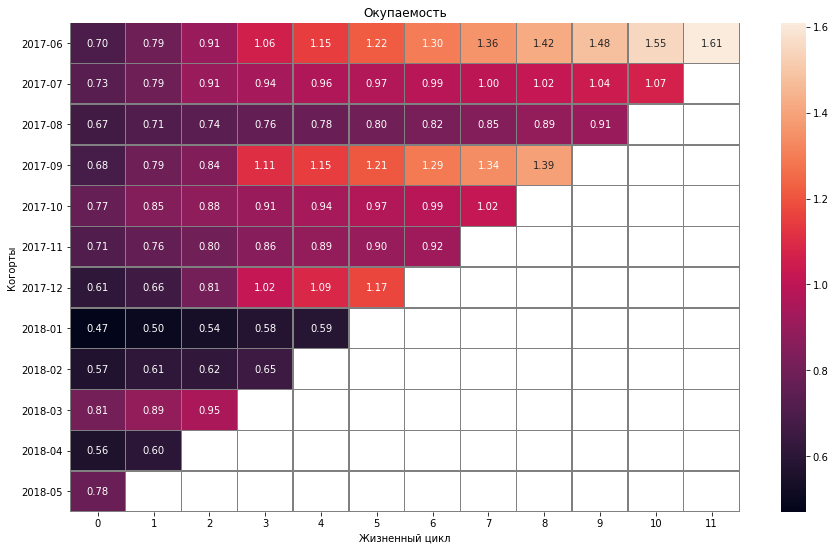

In [111]:
plt.figure(figsize=(15, 9))
plt.title('Окупаемость')
sns.heatmap(output.cumsum(axis=1).round(2), annot=True, fmt='.2f', linewidths=0.5, linecolor='gray')
plt.xlabel('Жизненный цикл')
plt.ylabel('Когорты')

Мы видим, что 4 когорты окупились, причем весьма быстро.

1. Июньская когорта окупилась на 3 месяц (ROMI = 1.06).
2. Июльская когорта окупилась на 7 месяц тоже (ROMI = 1.00).
3. Сентябрьская когорта окупилась на 3 месяц (ROMI = 1.10).
4. Декабрьская когорта окупилась на 3 месяц тоже (ROMI = 1.02).

Узнаем, как быстро в среднем когорты окупаются.

In [112]:
output.cumsum(axis=1).mean(axis=0)

age
0     0.671704
1     0.722460
2     0.800356
3     0.875083
4     0.943710
5     1.034912
6     1.050649
7     1.113914
8     1.179290
9     1.144248
10    1.310714
11    1.606402
dtype: float64

Из отчета мы видим, что в среднем когорты окупаются на 5 месяц жизни.

Ниже представлены таблицы сданными об изменении доходов и расходов с течением времени по источнику трафика и по определенному устройству.

In [113]:
result_grouped = afisha_order.groupby(['order_month', 'source_id', 'device']).agg({'uid':'nunique', 'revenue':'sum', 'costs':'mean'}).reset_index()

#### Изменение доходов по месяцам для источников трафика.

In [114]:
source_grouped_1 = (result_grouped.pivot_table(index='source_id', 
                                     columns='order_month', 
                                     values='revenue')
         )
source_grouped_1

order_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01
source_id,,,,,,,,,,,,
1,689.350,790.840,720.745,1535.805,1810.910,1759.740,1374.185,1277.410,1175.545,1939.385,1223.32,1248.040
2,521.840,934.455,464.510,1205.090,2658.395,2306.550,2331.055,1486.680,3282.750,3955.995,1715.75,2598.735
3,1402.170,1598.895,982.485,2329.435,3062.570,3235.515,3022.800,2358.010,2494.580,2588.700,1703.65,2476.810
4,979.920,1441.645,906.540,1550.345,3002.095,3572.195,3763.125,2261.910,2838.080,3390.890,2311.81,2328.150
5,949.445,1291.470,1062.870,2224.005,2768.760,1988.715,7204.375,1980.915,2530.890,1863.740,1171.63,1275.195
9,121.345,118.635,148.385,229.935,404.760,364.205,325.005,191.375,289.275,338.830,159.62,188.330
10,114.675,93.795,93.245,98.140,286.360,308.045,173.755,152.265,169.150,339.755,143.25,252.730


#### Изменение расходов по месяцам для источников трафика.

In [115]:
source_grouped_2 = (result_grouped.pivot_table(index='source_id', 
                                     columns='order_month', 
                                     values='costs')
         )
source_grouped_2

order_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01
source_id,,,,,,,,,,,,
1,43.610619,40.951786,28.740732,58.431097,75.626719,110.740903,76.450863,73.447350,80.608760,66.999800,46.903196,61.985143
2,90.673180,100.738803,63.475571,108.700696,163.619952,235.870671,160.665073,138.604675,166.086113,134.378166,105.470560,138.811334
3,320.605576,269.794604,201.567026,353.803006,540.328772,728.845753,523.131188,482.066119,533.775730,457.886531,328.238462,372.111490
4,115.224736,139.876319,108.349364,184.017315,208.138509,181.190051,253.902529,200.086335,213.543705,201.795578,155.530805,163.655665
5,95.782287,102.160649,74.312455,134.944182,188.567280,244.929462,190.763302,172.322714,181.012137,161.876689,125.742269,143.357052
9,9.842524,10.066636,7.854587,14.147457,20.217109,31.064614,22.213620,18.590777,21.108559,20.194514,12.949201,12.979062
10,13.837857,10.334264,10.439770,14.971706,21.886450,32.127492,22.239667,17.487884,19.503627,19.764472,13.760387,16.016092


#### Изменение доходов по месяцам для устройств.

In [116]:
device_grouped_1 = (result_grouped.pivot_table(index='device', 
                                     columns='order_month', 
                                     values='revenue')
         )
device_grouped_1

order_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01
device,,,,,,,,,,,,
desktop,1188.767143,1464.541429,1036.767143,2233.052857,3299.250000,3099.044286,4586.552857,2334.911429,3090.375714,3327.865714,2006.361429,2521.814286
touch,176.588571,326.811429,214.312857,387.734286,698.992857,768.088571,611.818571,438.964286,561.130000,791.361429,401.932857,440.468571


#### Изменение расходов по месяцам для устройств.

In [117]:
device_grouped_2 = (result_grouped.pivot_table(index='device', 
                                     columns='order_month', 
                                     values='costs')
         )
device_grouped_2

order_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01
device,,,,,,,,,,,,
desktop,101.934669,98.250879,72.578612,123.685609,172.869959,227.442474,180.772446,157.625731,171.470932,151.501738,114.044654,126.178805
touch,95.087268,94.298567,68.775533,124.604522,175.239981,219.634368,176.189338,157.404513,175.854391,152.182762,111.268168,133.511435


### Шаг 3. Вывод. Рекомендации маркетологам, куда и сколько им стоит вкладывать денег? <a id="step3"></a>   
</div>

По полученным данным получается, что у сервиса 3043 клиента в месяц, 702 в неделю и 101 в день в среднем.

Летом количество пользователей Яндекс.Афиши резко уменьшается. Это связано с тем, что летом люди стараются уехать из города на отдых. Также летом происходят театральные каникулы, а значит некоторый пласт пользователей, который увлекается театром отпадает.

Среднее количество сессий в день равно 139,8. Учитывая, что пользователей в день выходит 101, значит клиенты обращаются к сервису в день повторно.

Самое большое количество сессий длятся до 60 секунд.

Возвращаются люди очень редко по сравнению с самым первым циклом.

- Больше всех показатель возвращаемости у первой когорты. Там отметка возврата не падает ниже 4%.
- На второй период больше всего вернулось пользователей в когорте 2017-09.

Возможно сервису необходимо вести более активную рекламную кампанию и придумать какие- нибудь программы лояльности, чтобы пользователи чаще возвращались.

По ходу изучения данной нам информации мы увидели, что в среднем когорты окупаются на 5 месяц жизни. Такой результат очень медленный, а значит необходимо менять маркетинговую стратегию.

1. Июньская когорта окупилась на 3 месяц (ROMI = 1.06).
2. Июльская когорта окупилась на 7 месяц тоже (ROMI = 1.00).
3. Сентябрьская когорта окупилась на 3 месяц (ROMI = 1.10).
4. Декабрьская когорта окупилась на 3 месяц тоже (ROMI = 1.02).

Средний САС равен 10.6.

Вашему вниманию представлены две диаграммы, на которых мы можем увидеть какой процент расхода и дохода вложен в определенном источнике трафика.

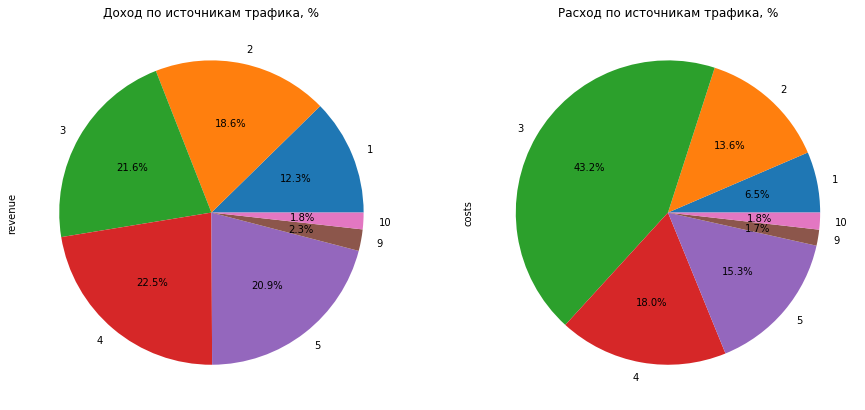

In [118]:
plt.subplots(figsize=(15,15))
pie_revenue = result_grouped.groupby('source_id').agg({'revenue':'sum'})
pie_costs = result_grouped.groupby('source_id').agg({'costs':'sum'})
pie_revenue.plot(kind='pie', y='revenue', grid=True, autopct='%1.1f%%', legend=False, ax=plt.subplot(1,2,1))
plt.title('Доход по источникам трафика, %')
pie_costs.plot(kind='pie', y='costs', grid=True, autopct='%1.1f%%', legend=False, ax=plt.subplot(1,2,2))
plt.title('Расход по источникам трафика, %')
plt.show()

Так как нам необходимо было выявить погрешности в распределении рекламного бюджета, то тут мы видим, что источник трафика под номером 3 не окупает себя. В него мы вкладываем половину от бюджета, а приносит он только 21,6% от всего дохода. Это даже не самый максимальный доход. При это источники трафика 2 и 5 окупают себя примерно в 1,5 раза. В связи с этим маркетинговому отделу рекомендуется для этих источников увеличить бюджет.

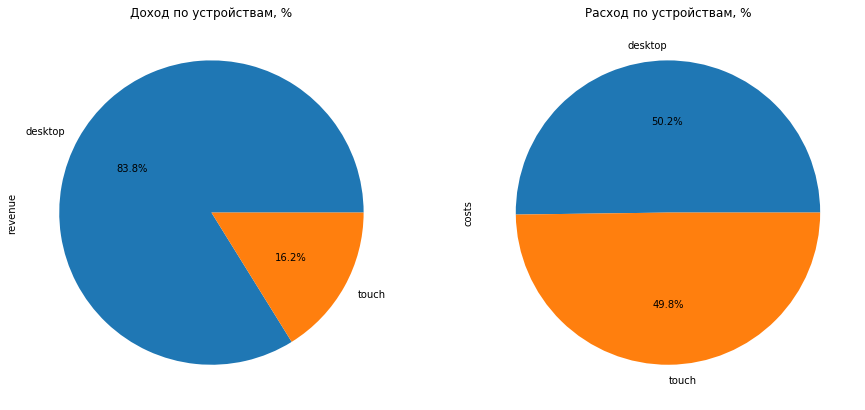

In [119]:
plt.subplots(figsize=(15,15))
pie_revenue = result_grouped.groupby('device').agg({'revenue':'sum'})
pie_costs = result_grouped.groupby('device').agg({'costs':'sum'})
pie_revenue.plot(kind='pie', y='revenue', grid=True, autopct='%1.1f%%', legend=False, ax=plt.subplot(1,2,1))
plt.title('Доход по устройствам, %')
pie_costs.plot(kind='pie', y='costs', grid=True, autopct='%1.1f%%', legend=False, ax=plt.subplot(1,2,2))
plt.title('Расход по устройствам, %')
plt.show()